# Monte Carlo Simulation for Estimating Pi

Monte Carlo methods are widely used for numerical simulations, optimization problems, and probabilistic modeling.
One of the classic problems that showcase the power of Monte Carlo simulations is estimating the value of $\pi$.

The idea is simple: randomly generate points inside a square and count how many fall within a quarter-circle.
The ratio of points inside the quarter-circle to the total number of points gives an approximation of $\pi$.

This approach leverages the relationship between the areas of a quarter circle (with radius $r$) and its bounding square (with side length r):

- Area of quarter circle = $\frac{\pi r^2}{4}$
- Area of square = $r^2$

Therefore, the ratio of these areas is:

$$
\frac{\text{Area of quarter circle}}{\text{Area of square}} = \frac{\pi r^2/4}{r^2} = \frac{\pi}{4}
$$

Thus,

$$
\pi = 4 \cdot \frac{\text{Area of quarter circle}}{\text{Area of square}}
$$

As we increase the number of random points, our approximation becomes more accurate, demonstrating the law of large numbers in action.
While this isn't the most efficient way to calculate $\pi$, it elegantly demonstrates how randomized algorithms can solve deterministic problems and introduces key concepts in parallel computing.

## Our approach

To computationally estimate the ratio using the Monte Carlo method, we need to:

1. Generate a large number of random points within a unit square (with coordinates from 0 to 1).
2. Determine which points lie within a quarter circle.
3. Calculate the ratio of points inside the circle to total points generated.

A point (x, y) lies within a quarter circle of radius 1 if the distance from the point to the origin is less than or equal to 1.
Using the Pythagorean theorem, this means that a point is inside the quarter circle if:

$x^2 + y^2 \leq 1$


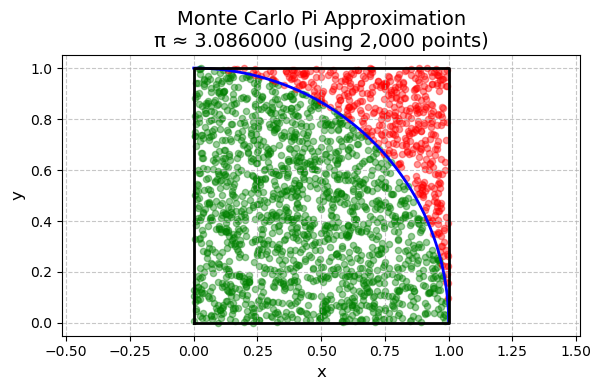

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random


def visualize_monte_carlo_pi(num_points=1000):
    """
    Visualize the Monte Carlo method for estimating Pi using a quarter circle and square.

    Args:
        num_points: Number of random points to generate

    Returns:
        The matplotlib figure object
    """
    # Create a new figure with specified size
    plt.figure(figsize=(6, 4))

    # Set up the quarter circle
    theta = np.linspace(0, np.pi / 2, 100)
    x_circle = np.cos(theta)
    y_circle = np.sin(theta)

    # Plot the quarter circle
    plt.plot(x_circle, y_circle, "b-", linewidth=2, label="Quarter Circle (r=1)")

    # Plot the square
    plt.plot([0, 1, 1, 0, 0], [0, 0, 1, 1, 0], "k-", linewidth=2, label="Unit Square")

    # Generate random points
    points_x = [random.uniform(0, 1) for _ in range(num_points)]
    points_y = [random.uniform(0, 1) for _ in range(num_points)]

    # Determine which points are inside the quarter circle
    inside_circle = []
    outside_circle = []

    for x, y in zip(points_x, points_y):
        if x**2 + y**2 <= 1:
            inside_circle.append((x, y))
        else:
            outside_circle.append((x, y))

    # Convert to numpy arrays for easier plotting
    inside_x, inside_y = zip(*inside_circle) if inside_circle else ([], [])
    outside_x, outside_y = zip(*outside_circle) if outside_circle else ([], [])

    # Plot points inside the quarter circle
    plt.scatter(
        inside_x,
        inside_y,
        color="green",
        alpha=0.4,
        s=20,
        label="Inside (n={})".format(len(inside_circle)),
    )

    # Plot points outside the quarter circle but inside the square
    plt.scatter(
        outside_x,
        outside_y,
        color="red",
        alpha=0.4,
        s=20,
        label="Outside (n={})".format(len(outside_circle)),
    )

    # Calculate the Pi approximation
    if num_points > 0:
        pi_approx = 4 * len(inside_circle) / num_points
        plt.title(
            f"Monte Carlo Pi Approximation\nπ ≈ {pi_approx:.6f} (using {num_points:,} points)",
            fontsize=14,
        )

    # Set up the plot
    plt.axis("equal")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xlabel("x", fontsize=12)
    plt.ylabel("y", fontsize=12)

    return plt.gcf()


# Generate and display the visualization
fig = visualize_monte_carlo_pi(2000)
plt.tight_layout()
plt.show()

## How Parallelization Helps

The Monte Carlo estimation of $\pi$ is a textbook example of an "embarrassingly parallel" problem.

1. **Complete Independence**: Each random sample is independent of all other samples.
2. **No Shared State**: Workers don't need to communicate or synchronize with each other.
3. **Minimal Overhead**: The computation-to-communication ratio is extremely high.
4. **Linear Scaling**: Doubling the computing resources can nearly double the throughput.
5. **Simple Aggregation**: Results from all workers can be combined with a simple sum.


In [2]:
from raygent import Task


class MonteCarloPiTask(Task):

    def process_item(self, item: int) -> int:
        """Simulates a Monte Carlo experiment for estimating Pi.

        For each task, generates `item` random points within a unit square (0,0 to 1,1)
        and counts how many fall inside the quarter-circle with radius 1 centered at
        the origin. This count can later be used to approximate π by calculating:
        π ≈ 4 * (points_inside_circle / total_points)

        Args:
            item: The number of random points to generate in this task instance.

        Returns:
            The count of points that fell inside the quarter-circle.
        """
        inside_circle = 0

        # Generate the specified number of random points
        for _ in range(item):
            # Generate random coordinates between 0 and 1
            x, y = random.uniform(0, 1), random.uniform(0, 1)

            # Check if the point falls within the quarter-circle
            # A point (x,y) is inside the circle if x² + y² ≤ 1
            if x**2 + y**2 <= 1:
                inside_circle += 1

        return inside_circle

Here, the method [`process_item`](https://raygent.oasci.org/api/task/#task.Task.process_item) takes an integer parameter representing the number of points to generate in each task.
It then:

1. Creates the specified number of random points with x and y coordinates between 0 and 1;
2. Checks each point to see if it falls within the quarter-circle (where x² + y² ≤ 1);
3. Counts and returns the total number of points that landed inside the quarter-circle.

Each task instance will process its own batch of points independently, allowing the workload to be distributed efficiently across multiple cores or machines.

## Running the Task with `TaskManager`

The `raygent` framework's [`TaskManager`](https://raygent.oasci.org/api/manager/#manager.TaskManager) enables us to distribute this workload efficiently:

1. We divide our desired total number of samples into smaller chunks.
2. Each chunk becomes an independent task assigned to worker processes.
3. Multiple CPU cores process these tasks simultaneously.
4. The framework handles all the task scheduling and result collection.
5. Results are aggregated to calculate the final π approximation.

This approach can achieve near-linear speedup relative to the number of CPU cores available.
For example, on a 16-core machine, we can potentially compute results up to 16 times faster than using a single core.
Even better, by leveraging Ray's distributed computing capabilities through [`TaskManager`](https://raygent.oasci.org/api/manager/#manager.TaskManager), we can scale beyond a single machine to a cluster of computers with minimal code changes.

Our `MonteCarloPiTask` class encapsulates the core algorithm while [`TaskManager`](https://raygent.oasci.org/api/manager/#manager.TaskManager) handles all the complexities of distributing the work, making parallelization straightforward and effective.


In [3]:
from raygent import TaskManager


def estimate_pi(n_workers: int, samples_per_worker: int) -> float:
    """Estimates Pi using Monte Carlo simulation with parallel execution.

    Args:
        n_workers: Number of independent Monte Carlo simulations to run.
        samples_per_worker: Number of points each worker will generate.

    Returns:
        Estimated value of π.
    """
    manager = TaskManager(MonteCarloPiTask, n_cores=n_workers, use_ray=True)

    manager.submit_tasks(items=[samples_per_worker] * n_workers, at_once=False)
    results = manager.get_results()

    total_inside_circle = sum(results)
    total_samples = samples_per_worker * n_workers

    pi_estimate = (total_inside_circle / total_samples) * 4
    return pi_estimate

In [4]:
estimated_pi = estimate_pi(n_workers=8, samples_per_worker=1_000_000)
print(f"Estimated π: {estimated_pi}")

2025-03-07 09:32:40,684	INFO worker.py:1841 -- Started a local Ray instance.


Estimated π: 3.1409545
